In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import *
import re
from sklearn.feature_extraction import text
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# hide warnings
import warnings 
warnings.filterwarnings("ignore")

In [2]:
training_data = pd.read_csv('Data/train.csv', index_col = [0])

In [3]:
test_data = pd.read_csv('Data/test.csv', index_col = [0])

In [4]:
training_data.product_description = training_data.product_description.fillna('')
test_data.product_description = test_data.product_description.fillna('')

Preprocessing

In [5]:
# stop word removal
stemmer = PorterStemmer()
sw=[]
ML_STOP_WORDS = ['http','www','img','border','color','style','padding','table','font','inch','width','height']
ML_STOP_WORDS += list(text.ENGLISH_STOP_WORDS)
for stw in ML_STOP_WORDS:
    sw.append(str(stw))
ML_STOP_WORDS += sw
for i in range(len(ML_STOP_WORDS)):
    ML_STOP_WORDS[i]=stemmer.stem(ML_STOP_WORDS[i])

In [6]:
# declarations
def ML_TEXT_CLEAN(f2,f3):
    if len(f2)<3:
        f2="feature2null"
    if len(f3)<3:
        f3="feature3null"
    tx = BeautifulSoup(f3)
    tx1 = [x.extract() for x in tx.findAll('script')]
    tx = tx.get_text(" ").strip()
    s = (" ").join(["z"+ str(z) for z in f2.split(" ")]) + " " + tx
    s = re.sub("[^a-zA-Z0-9]"," ", s)
    s = re.sub("[0-9]{1,3}px"," ", s)
    s = re.sub(" [0-9]{1,6} |000"," ", s)
    s = (" ").join([stemmer.stem(z) for z in s.split(" ") if len(z)>2])
    s = s.lower()
    return s

In [7]:
# Cleaning training data
s_data = []
for i in range(len(training_data.id)):
    s = ML_TEXT_CLEAN(training_data.product_title[i], training_data.product_description[i])
    s_data.append((training_data["query"][i], s, str(training_data["median_relevance"][i])))

In [8]:
# Cleaning test data
t_data = []
for i in range(len(test_data.id)):
    s = ML_TEXT_CLEAN(test_data.product_title[i], test_data.product_description[i])
    t_data.append((test_data["query"][i], s, str(test_data["median_relevance"][i])))

In [9]:
training_df = pd.DataFrame(s_data)
test_df = pd.DataFrame(t_data)

In [10]:
training_df.shape

(7618, 3)

In [11]:
test_df.shape

(2540, 3)



---



SVM

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
clf = Pipeline([('v',TfidfVectorizer(max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 6),
                                     use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = ML_STOP_WORDS)),
                ('svd', TruncatedSVD(n_components=100)),  ('scl', StandardScaler()), ('svm', SVC(C=10))])

# Concatenate the two features into a single feature
training_data = training_df[0] + ' ' + training_df[1]

# Fit the model on the training data
clf.fit(training_data, training_df[2])

# Concatenate the two features into a single feature for the test data
test_data = test_df[0] + ' ' + test_df[1]

# Predict the output feature for the test data
predictions = clf.predict(test_data)

In [14]:
print(classification_report(test_df[2], predictions))

              precision    recall  f1-score   support

           1       0.68      0.11      0.19       186
           2       0.38      0.19      0.26       337
           3       0.37      0.10      0.15       451
           4       0.66      0.94      0.78      1566

    accuracy                           0.63      2540
   macro avg       0.52      0.34      0.34      2540
weighted avg       0.57      0.63      0.55      2540



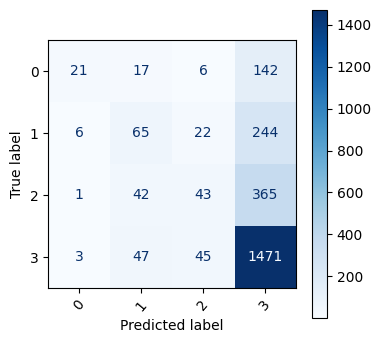

In [22]:
# plot the confusion matrix
svm_cm = confusion_matrix(test_df[2], predictions)
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)

svm_disp.plot(cmap=plt.cm.Blues)
svm_disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()



---



Grid search

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [17]:

svm_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=None, strip_accents='unicode', analyzer='word', 
                                    token_pattern=r'\w{1,}', ngram_range=(1, 6),
                                    use_idf=True, smooth_idf=True, sublinear_tf=True, 
                                    stop_words=ML_STOP_WORDS)),
    ('svd', TruncatedSVD(n_components=100)),  
    ('scl', StandardScaler()), 
    ('svm', SVC())])

# Hyperparameter for grid search
param_grid = {'svm__C': [0.1, 1, 10],
              'svm__kernel': ['linear', 'rbf']}

In [18]:
# Grid search using cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(training_data, training_df[2])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 6),
                                                        stop_words=['http',
                                                                    'www',
                                                                    'img',
                                                                    'border',
                                                                    'color',
                                                                    'style',
                                                                    'pad',
                                                                    'tabl',
                                                                    'font',
                                                                    'inch',
                                                                    'width',
                                                                    'height',
                                                                    'might',
                                                                    'alon',
                                                                    'everyon',
                                                                    'and',
                                                                    'becom',
                                                                    'un',
                                                                    'least',
                                                                    'though',
                                                                    'or',
                                                                    'back',
                                                                    'hereaft',
                                                                    'some',
                                                                    'up',
                                                                    'five',
                                                                    'someon',
                                                                    'abov',
                                                                    'more',
                                                                    'yet', ...],
                                                        strip_accents='unicode',
                                                        sublinear_tf=True,
                                                        token_pattern='\\w{1,}')),
                                       ('svd', TruncatedSVD(n_components=100)),
                                       ('scl', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__kernel': ['linear', 'rbf']},
             verbose=1)

In [19]:
# Best hyperparameters and score
print('Best parameters: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)

Best parameters:  {'svm__C': 10, 'svm__kernel': 'rbf'}
Best score:  0.6185329755645286


In [20]:
y_pred = grid_search.predict(test_data)
print(classification_report(test_df[2], y_pred))

              precision    recall  f1-score   support

           1       0.67      0.09      0.15       186
           2       0.35      0.20      0.25       337
           3       0.35      0.09      0.14       451
           4       0.66      0.93      0.77      1566

    accuracy                           0.62      2540
   macro avg       0.51      0.33      0.33      2540
weighted avg       0.57      0.62      0.55      2540

